In [1]:
%reset -sf

In [9]:
import torch
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from opt_einsum import contract
from torch.profiler import profile, record_function, ProfilerActivity
def _toN(t):
    return t.detach().cpu().numpy()
def printDiff(name,value,ref):
    if ref is not None:
        print(name+':',value,'diff(abs):',value-ref)
    else:
        print(name+':',value)
import os
if '__file__' in globals():
    script_name=os.path.splitext(os.path.basename(__file__))[0]
else:
    script_name='test'


# SRG BaseClass

In [10]:
class SRG(torch.nn.Module):
    def __init__(self,params,options):
        super(SRG,self).__init__()
        self.dtype=options.get('dtype',torch.float64)
        self.device=options.get('device','cpu')
        self.max_dim=options.get('max_dim',16)
        self.nLayers=options.get('nLayers',10)
        self.use_checkpoint=options.get('use_checkpoint',True)
        self.observable_checkerboard=False
        
        self.params=torch.nn.ParameterDict({
            k:torch.nn.Parameter(torch.tensor(v,dtype=self.dtype,device=self.device)) for k,v in params.items()
        })
        self.logZ=0
        self.logZ_diff=0
        
    def __str__(self):
        rtval=""
        for k,v in self.params.items():
            rtval+=k+':'+v+'\n'
        rtval+='dtype:'+self.dtype+'\n'
        rtval+='device:'+self.device+'\n'
        rtval+='max_dim:'+self.max_dim+'\n'
        rtval+='nLayers:'+self.nLayers+'\n'
        rtval+='nSite:'+2**nLayers+'\n'
        
    def set_params(self,params):
        self.params=torch.nn.ParameterDict({
            k:torch.nn.Parameter(torch.tensor(v,dtype=self.dtype,device=self.device)) for k,v in params.items()
        })
        
    def toT(self,t):
        return torch.tensor(t,dtype=self.dtype,device=self.device)
    
    def generate_random_Isometry(self,dim1,dim2):
        dim=max(dim1,dim2)
        A=torch.randn(dim,dim,dtype=self.dtype,device=self.device)
        U=torch.matrix_exp(A-A.t())
        U=U[:dim1,:dim2]
        return U
    
    def TRG_same_T(self,T,*w):
        return self.TRG(T,T,*w)
    
    def forward_tensor(self):
        logTotal=0
        T=self.get_T0()
        for i in range(self.nLayers):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            if self.use_checkpoint:
                T=torch.utils.checkpoint.checkpoint(self.TRG_same_T,T,*w)
            else:
                T=self.TRG_same_T(T,*w)
                
            norm=torch.linalg.norm(T)
            T=T/norm
            logTotal=2*logTotal+torch.log(norm)
        return T,logTotal
    
    def forward_tensor_with_observable(self,T_op):
        logTotal=0
        T=self.get_T0()
        for i in range(self.nLayers):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            if self.use_checkpoint:
                T1=torch.utils.checkpoint.checkpoint(self.TRG_same_T,T,*w)
                T2=torch.utils.checkpoint.checkpoint(self.TRG,T,T_op,*w)
                T3=torch.utils.checkpoint.checkpoint(self.TRG,T_op,T,*w)
            else:
                T1=self.TRG_same_T(T,*w)
                T2=self.TRG(T,T_op,*w)
                T3=self.TRG(T_op,T,*w)
            if self.observable_checkerboard and i<self.spacial_dim:
                T3=-T3

            T,T_op=T1,(T2+T3)/2
            norm=torch.linalg.norm(T)
            T,T_op=T/norm,T_op/norm
            logTotal=2*logTotal+torch.log(norm)
        return T,T_op,logTotal
    
    
    def dlogZ(self,param):
        self.requires_grad_(False)
        self.params[param].requires_grad_(True)
        self.zero_grad()
        logZ=self.forward()
        logZ.backward()
        result=_toN(self.params[param].grad)
        self.params[param].requires_grad_(False)
        return result
    
    def update_single_layer(self,layer,calc_diff=True):
        self.requires_grad_(False)
        
        for i in range(layer*self.w_per_layer,(layer+1)*self.w_per_layer):
            self.ws[i].requires_grad_(True)
        self.zero_grad()
        
        logZ=self.forward()
        logZ.backward()
        
        with torch.no_grad():
            for i in range(layer*self.w_per_layer,(layer+1)*self.w_per_layer):
                E=self.ws[i].grad
                dim1,dim2=E.shape[0],E.shape[2]
                E=E.reshape(dim1*dim1,dim2)
                U,S,Vh=torch.linalg.svd(E,full_matrices=False)
                UVh=U@Vh
                #UVh=svd2UVh(E)
                del U,S,Vh,E
                if calc_diff:
                    UVh_old=self.ws[i].reshape(dim1*dim1,dim2)
                    diff=[]
                    diff.append(_toN(torch.norm(UVh_old-UVh))) # direct difference
                    diff.append(_toN(torch.norm(UVh_old@UVh_old.t()-UVh@UVh.t())))# difference of projectors
                    diff.append(_toN(torch.norm(UVh_old.t()@UVh@UVh.t()@UVh_old-torch.eye(dim2,device=UVh.device))))# ???
                    self.current_ws_diff[i]=np.array(diff)
                    del UVh_old
                self.ws[i].data=UVh.reshape(dim1,dim1,dim2)
                del UVh
                torch.cuda.empty_cache()
        return _toN(logZ)
        
    def optimize(self,nIter):
        torch.cuda.empty_cache()
        if nIter>1:
            pbar2=tqdm(range(nIter), leave=False)
            pbar2.set_postfix({k:_toN(v) for k,v in self.params.items()})
        else:
            pbar2=range(nIter)
        for i in pbar2:
            pbar=tqdm(range(self.nLayers-1,-1,-1), leave=False)
            for j in pbar:
                new_logZ=self.update_single_layer(j)
        #lock all grads
        for param in self.params.values(): 
            param.requires_grad_(False)
        for i in range(self.nLayers): #slightly faster
            self.ws[i].requires_grad_(False)
        
        self.logZ_diff=np.abs(self.logZ-new_logZ)
        self.logZ=new_logZ


In [11]:
class HOTRG(SRG):
    def __init__(self,params,options):
        super(HOTRG,self).__init__(params,options)
    
    def create_isometries(self,start_dim,spacial_dim):
        ws=[]
        bond_dim=[start_dim]*spacial_dim
        for i in range(self.nLayers):
            for j in range(1,spacial_dim):
                old_dim=bond_dim[j]
                new_dim=min(old_dim**2,self.max_dim)
                U=self.generate_random_Isometry(old_dim**2,new_dim).view(old_dim,old_dim,new_dim)
                ws.append(U.detach())
                bond_dim[j]=new_dim
            bond_dim=bond_dim[1:]+[bond_dim[0]]
        self.ws=torch.nn.ParameterList([
            torch.nn.Parameter(v) for v in ws
        ])
        self.w_per_layer=spacial_dim-1
        self.spacial_dim=spacial_dim
        self.current_ws_diff=[0]*len(self.ws)
        
    def HOTRG2D(self,T1,T2,w):
        return contract('ijkl,jmno,kna,lob->abim',T1,T2,w,w)#contract and rotate
    
    def HOTRG3D(self,T1,T2,w1,w2):
        return contract('ijklmn,jopqrs,kpa,lqb,mrc,nsd->abcdio',T1,T2,w1,w1,w2,w2)#contract and rotate
    
    def forward(self):
        T,logTotal=self.forward_tensor()
        contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
        Z=contract(T,contract_all)
        return (torch.log(Z)+logTotal)/2**self.nLayers
    
    def forward_with_observable(self,T_op):
        T,T_op,_=self.forward_tensor_with_observable(T_op)
        contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
        Z=contract(T,contract_all)
        Z_op=contract(T_op,contract_all)
        return Z_op/Z


# AKLT Public

In [5]:
from scipy.special import comb
def get_CG_no_normalization(n):
    if n==0:
        return np.eye(1)
    CG=np.zeros((n+1,)+(2,)*n)
    for i in range(2**n):
        indices=tuple(map(int,bin(i)[2:].zfill(n)))
        m=np.sum(indices)
        CG[(m,)+indices]=1
    return CG
def get_CG(n):
    if n==0:
        return np.eye(1)
    CG=np.zeros((n+1,)+(2,)*n)
    for i in range(2**n):
        indices=tuple(map(int,bin(i)[2:].zfill(n)))
        m=np.sum(indices)
        CG[(m,)+indices]=1/np.sqrt(comb(n,m))
    return CG
def get_Singlet():
    return np.array([[0,1.],[-1.,0]])

print(get_CG_no_normalization(4).reshape(5,-1))
print(get_CG(3).reshape(4,-1))
assert get_CG(3).shape==(4,2,2,2)
assert np.isclose(get_CG(3).reshape(4,-1)@get_CG(3).reshape(4,-1).T,torch.eye(4)).all()
print(get_Singlet())
assert np.isclose(get_Singlet()@get_Singlet(),-torch.eye(2)).all()
assert (get_Singlet()==-get_Singlet().T).all()


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.57735027 0.57735027 0.         0.57735027 0.
  0.         0.        ]
 [0.         0.         0.         0.57735027 0.         0.57735027
  0.57735027 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.        ]]
[[ 0.  1.]
 [-1.  0.]]


# AKLT 2D

In [6]:
class AKLT2D(HOTRG):
    default_params={'a1':np.sqrt(6)/2,'a2':np.sqrt(6)}
    def __init__(self,params,options):
        super(AKLT2D,self).__init__(params,options)
        self.create_isometries(start_dim=4,spacial_dim=2)
        self.TRG=self.HOTRG2D
        self.observable_checkerboard=True
        self.magnetization=0
        self.magnetization_diff=0
        
        
    def get_T0(self):
        projector=self.toT(get_CG_no_normalization(4))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2=self.toT(1),self.params['a1'],self.params['a2']
        deform=torch.stack([ac2,ac1,ac0,ac1,ac2])
        node=contract('aijkl,im,kn,a->amjnl',projector,singlet,singlet,deform)
        return contract('aijkl,amnop->imjnkolp',node,node).reshape(4,4,4,4)#UDLR

    def get_SZT0(self):
        projector=self.toT(get_CG_no_normalization(4))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2=self.toT(1),self.params['a1'],self.params['a2']
        deform=torch.stack([ac2,ac1,ac0,ac1,ac2])
        node=contract('aijkl,im,kn,a->amjnl',projector,singlet,singlet,deform)
        op=self.toT([2,1,0,-1,-2])
        return contract('aijkl,amnop,a->imjnkolp',node,node,op).reshape(4,4,4,4)#UDLR
    
    def calc_magnetization(self):
        with torch.no_grad():
            new_magnetization=_toN(torch.abs(self.forward_with_observable(self.get_SZT0())))
            self.magnetization_diff=np.abs(self.magnetization-new_magnetization)
            self.magnetization=new_magnetization


# Test

In [7]:
options={
    'dtype':torch.float64,
    'device':'cuda:1',
    'max_dim':30, # 50 for float32
    'nLayers':40,
    'use_checkpoint':True
}
print(options)

MAX_ITER=100
a2s=[1.77,1.78,1.79]

data=pd.DataFrame()
srg=AKLT2D(AKLT2D.default_params,options)

for a2 in a2s:
    params={'a1':0,'a2':a2}
    srg=AKLT2D(params,options)
    
    pbar=tqdm(range(MAX_ITER))
    for _iter in pbar:
        
        srg.optimize(1)
        srg.calc_magnetization()
        
        pbar.set_postfix({'ΔlogZ':srg.logZ_diff,'Δm':srg.magnetization_diff})
        
        newRow={'a1':params['a1'],'a2':params['a2'],'iter':_iter+1,
                'logZ':srg.logZ,'magnetization':srg.magnetization,
                'diff_logZ':srg.logZ_diff,'diff_magnetization':srg.magnetization_diff,
               }
        data=data.append(newRow,ignore_index=True)
        data.to_csv(script_name+'.csv')
        
        #if srg.magnetization_diff>1.1*average_dm:
            #break
            
    for k,v in newRow.items():
        print(k,':',v,end=' ')
    print()


{'dtype': torch.float64, 'device': 'cuda:1', 'max_dim': 15, 'nLayers': 15, 'use_checkpoint': True}


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

/home/wenhan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

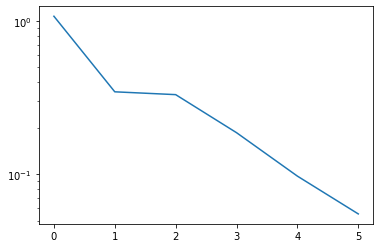

In [8]:
plt.plot(data['diff_magnetization'])
plt.yscale('log')
plt.show()

## Convergence Logic

In [179]:
options={
    'dtype':torch.float64,
    'device':'cuda:1',
    'max_dim':20, # 50 for float32
    'nLayers':30,
    'use_checkpoint':True
}
print(options)

MAX_ITER=150
CONVERGENCE_COUNT=5
CONVERGENCE_LOGZ=5e-6
CONVERGENCE_MAGNETIZATION=5e-4
PHASE_TRANSIT_COUNT=5
COPY_PREVIOUS=True
a2s=[1.778,1.779,1.78,1.781,1.782,1.783,1.784,1.785,1.784,1.783,1.782,1.781,1.78,1.779,1.778]

data=pd.DataFrame()
srg=AKLT2D(AKLT2D.default_params,options)

for a2 in a2s:
    params={'a1':0,'a2':a2}
    srg.set_params(params)
    new_srg=False
    
    convergence=0
    phase_transit=0
    old_magnetization_diff=0
    
    pbar=tqdm(range(MAX_ITER))
    for _iter in pbar:
        
        srg.optimize(1)
        srg.calc_magnetization()
        
        pbar.set_postfix({'ΔlogZ':srg.logZ_diff,'Δm':srg.magnetization_diff})
        
        newRow={'a1':params['a1'],'a2':params['a2'],'iter':_iter+1,
                'logZ':srg.logZ,'magnetization':srg.magnetization,
                'diff_logZ':srg.logZ_diff,'diff_magnetization':srg.magnetization_diff,
               }
        data=data.append(newRow,ignore_index=True)
        data.to_csv(script_name+'.csv')
        
        # detect phase transit
        if srg.magnetization_diff>old_magnetization_diff*1.1 and not new_srg:
            phase_transit+=1
        else
            phase_transit=0
        if phase_transit>=PHASE_TRANSIT_COUNT:
            srg=AKLT2D(params,options)
            new_srg=True
            convergence=0
            continue
        
        # detect convergence
        if srg.logZ_diff<CONVERGENCE_LOGZ and srg.magnetization_diff<CONVERGENCE_MAGNETIZATION:
            convergence+=1
        else:
            convergence=0
            
        if (_iter+1)%10==0 or convergence>=CONVERGENCE_COUNT:
            for k,v in newRow.items():
                print(k,':',v,end=' ')
            print()
        
        if convergence>=CONVERGENCE_COUNT:
            print('Converged!')
            break
        elif _iter==MAX_ITER-1:
            print('Not Converged!')


{'dtype': torch.float64, 'device': 'cuda:1', 'max_dim': 20, 'nLayers': 30, 'use_checkpoint': True}


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.783 iter : 10 logZ : 1.1771302484663757 magnetization : 1.3710450413303223 diff_logZ : 7.571527849137283e-10 diff_magnetization : 1.379046965377384e-05 order : 0 
Converged!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.784 iter : 9 logZ : 1.1780377895367504 magnetization : 1.4259495185291524 diff_logZ : 8.330558465274862e-11 diff_magnetization : 8.634651283534467e-06 order : 0 
Converged!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.785 iter : 8 logZ : 1.1789553281479623 magnetization : 1.4639049427503315 diff_logZ : 3.906193146718806e-10 diff_magnetization : 8.213980514870656e-06 order : 0 
Converged!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.784 iter : 9 logZ : 1.1780377894724576 magnetization : 1.4259653555617864 diff_logZ : 1.0811640471786177e-10 diff_magnetization : 8.820918251162269e-06 order : 0 
Converged!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.783 iter : 10 logZ : 1.1771302490995912 magnetization : 1.371069073482853 diff_logZ : 6.358336079870242e-11 diff_magnetization : 1.3003640715769649e-05 order : 0 
Converged!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.782 iter : 10 logZ : 1.1762371891920809 magnetization : 1.2801732585445151 diff_logZ : 5.229661148575815e-11 diff_magnetization : 7.243534093426263e-05 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.782 iter : 12 logZ : 1.1762371892172727 magnetization : 1.280114339649292 diff_logZ : 7.2164496600635175e-12 diff_magnetization : 2.0505187483532694e-05 order : 0 
Converged!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.781 iter : 10 logZ : 1.1753683470397265 magnetization : 1.0897872349517852 diff_logZ : 1.31570487837962e-09 diff_magnetization : 0.0008767832740914638 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.781 iter : 16 logZ : 1.1753683479872614 magnetization : 1.088317131232469 diff_logZ : 1.332844945522993e-11 diff_magnetization : 6.274330258460026e-05 order : 0 
Converged!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.78 iter : 10 logZ : 1.1745501499232396 magnetization : 0.5450102252044781 diff_logZ : 1.9558990138612842e-07 diff_magnetization : 0.017890264213968665 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.78 iter : 20 logZ : 1.1745507402530748 magnetization : 0.44909257870748864 diff_logZ : 1.628097479056123e-08 diff_magnetization : 0.0054686735225341065 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.78 iter : 30 logZ : 1.17455080610045 magnetization : 0.4161567736879972 diff_logZ : 3.3139349042698996e-09 diff_magnetization : 0.002070558851215709 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.78 iter : 40 logZ : 1.1745509379105672 magnetization : 0.40247277531021625 diff_logZ : 3.706698503691541e-08 diff_magnetization : 0.0010527053827004695 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.78 iter : 50 logZ : 1.1745521501293397 magnetization : 0.38588644750864326 diff_logZ : 1.4897002120761726e-07 diff_magnetization : 0.002474753948565167 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.78 iter : 60 logZ : 1.1745528949175343 magnetization : 0.36009630758226213 diff_logZ : 2.955083955313853e-08 diff_magnetization : 0.0022489100356316016 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.78 iter : 70 logZ : 1.174553017888717 magnetization : 0.34369885537969036 diff_logZ : 4.87736562249097e-09 diff_magnetization : 0.0011979813240057258 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.78 iter : 80 logZ : 1.1745530400812716 magnetization : 0.33538917824350106 diff_logZ : 1.014847539337893e-09 diff_magnetization : 0.0005916214439083411 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.78 iter : 87 logZ : 1.1745530443858323 magnetization : 0.33224297071618253 diff_logZ : 4.0774561504974827e-10 diff_magnetization : 0.0003593486484506636 order : 0 
Converged!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.779 iter : 10 logZ : 1.1737950816808898 magnetization : 0.03777433118899681 diff_logZ : 3.888327748668985e-08 diff_magnetization : 0.006248201706476379 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.779 iter : 20 logZ : 1.1737951884155036 magnetization : 0.009997980368781361 diff_logZ : 2.5514144130767136e-09 diff_magnetization : 0.001303535030801663 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.779 iter : 30 logZ : 1.173795197399896 magnetization : 0.0030616303480514996 diff_logZ : 3.086872979451982e-10 diff_magnetization : 0.00037826355635648973 order : 0 


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.779 iter : 32 logZ : 1.1737951980527441 magnetization : 0.0024265840014867125 diff_logZ : 3.576239304692308e-10 diff_magnetization : 0.00029888364477170803 order : 0 
Converged!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 1.778 iter : 6 logZ : 1.1730492912060007 magnetization : 0.0003849406498063399 diff_logZ : 5.944611469743677e-10 diff_magnetization : 0.00010321171082045141 order : 0 
Converged!


# AKLT 3D

In [6]:
class AKLT3D(HOTRG):
    default_params={'a1':np.sqrt(20/15),'a2':np.sqrt(20/6),'a3':np.sqrt(20/1)}
    def __init__(self,params,options):
        super(AKLT3D,self).__init__(params,options)
        self.create_isometries(start_dim=4,spacial_dim=3)
        self.TRG=self.HOTRG3D
        self.observable_checkerboard=True
        self.magnetization=0
        self.magnetization_diff=0
        
    def get_T0(self):
        projector=self.toT(get_CG_no_normalization(6))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2,ac3=self.toT(1),self.params['a1'],self.params['a2'],self.params['a3']
        deform=torch.stack([ac3,ac2,ac1,ac0,ac1,ac2,ac3])
        node=contract('aijklmn,io,kp,mq,a->aojplqn',projector,singlet,singlet,singlet,deform)
        return contract('aijklmn,aopqrst->iojpkqlrmsnt',node,node).reshape(4,4,4,4,4,4)#UDLRFB

    def get_SZT0(self):
        projector=self.toT(get_CG_no_normalization(6))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2,ac3=self.toT(1),self.params['a1'],self.params['a2'],self.params['a3']
        deform=torch.stack([ac3,ac2,ac1,ac0,ac1,ac2,ac3])
        node=contract('aijklmn,io,kp,mq,a->aojplqn',projector,singlet,singlet,singlet,deform)
        op=self.toT([3,2,1,0,-1,-2,-3])
        return contract('aijklmn,aopqrst,a->iojpkqlrmsnt',node,node,op).reshape(4,4,4,4,4,4)#UDLRFB
    
    def calc_magnetization(self):
        with torch.no_grad():
            new_magnetization=_toN(torch.abs(self.forward_with_observable(self.get_SZT0())))
            self.magnetization_diff=np.abs(self.magnetization-new_magnetization)
            self.magnetization=new_magnetization

# Test

{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 9, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/home/wenhan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


a1 : 1.1547005383792515 a2 : 1.8257418583505538 a3 : 4.47213595499958 iter : 1 logZ : 2.5102084 magnetization : 2.5677452 


  0%|          | 0/20 [00:00<?, ?it/s]

a1 : 1.1547005383792515 a2 : 1.8257418583505538 a3 : 4.47213595499958 iter : 2 logZ : nan magnetization : 2.645212 


  0%|          | 0/20 [00:00<?, ?it/s]

a1 : 1.1547005383792515 a2 : 1.8257418583505538 a3 : 4.47213595499958 iter : 3 logZ : 3.112243 magnetization : 2.6171567 


  0%|          | 0/20 [00:00<?, ?it/s]

a1 : 1.1547005383792515 a2 : 1.8257418583505538 a3 : 4.47213595499958 iter : 4 logZ : 3.1136107 magnetization : 2.599793 


  0%|          | 0/20 [00:00<?, ?it/s]

a1 : 1.1547005383792515 a2 : 1.8257418583505538 a3 : 4.47213595499958 iter : 5 logZ : 3.1138358 magnetization : 2.5930178 


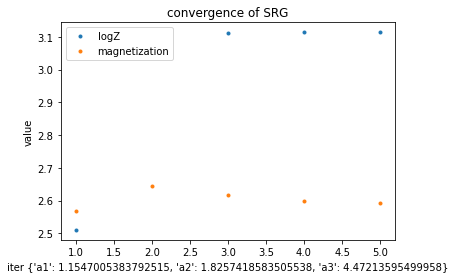

In [8]:
options={
    'dtype':torch.float32,
    'device':'cuda:0',
    'max_dim':9, # 12 for float32
    'nLayers':20,
    'use_checkpoint':True
}
print(options)

data=pd.DataFrame()
for a3 in [2]:
    #params={'a1':0,'a2':0,'a3':a3}
    params=AKLT3D.default_params
    srg=AKLT3D(params,options)
    
    for _iter in tqdm(range(5)):
        srg.optimize(1)
        newRow={'a1':params['a1'],'a2':params['a2'],'a3':params['a3'],'iter':_iter+1,'logZ':srg.current_logZ,'magnetization':srg.get_magnetization()}
        for k,v in newRow.items():
            print(k,':',v,end=' ')
        print()
        data=data.append(newRow,ignore_index=True)
        data.to_csv('saved_data.csv')

plt.plot(data['iter'],data['logZ'],'.')
plt.plot(data['iter'],np.abs(data['magnetization']),'.')
plt.xlabel(f'iter {params}')
plt.ylabel('value')
plt.legend(['logZ','magnetization'])
plt.title('convergence of SRG')
plt.show()

